In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
import pymie as pm
from pymie import size_parameter, index_ratio 
import seaborn as sns
import time

In [2]:
# Montecarlo parameters
ntrajectories = 30000                    # number of trajectories (min 35000 for decent results)
nevents = 200                           # number of scattering events in each trajectory (min 100 for decent result)

# Properties of system
wavelengths = sc.Quantity(np.arange(470, 740, 10), 'nm')
particle_radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '') # rcp .64
#n_imag = np.linspace(1.1e-4, 5e-5, wavelengths.size)
n_particle = ri.n('polystyrene', wavelengths) # + n_imag*1j    # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelengths)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelengths)      # space within sample. n_medium is outside the sample.3
z_low = sc.Quantity('0.0 um')
thickness = sc.Quantity('80 um')

# Properties of detector
det_theta = sc.Quantity('16 degrees')
det_dist = sc.Quantity('13 cm')
det_len = sc.Quantity('2.4 cm')#2.4

### Run Monte Carlo model and calculate reflectance and polarization for trajectories

In [3]:
pol_refl_x_sum = np.zeros(wavelengths.size)
pol_refl_y_sum = np.zeros(wavelengths.size)
pol_refl_z_sum = np.zeros(wavelengths.size)
pol_refl_loc_x_sum = np.zeros(wavelengths.size)
pol_refl_loc_y_sum = np.zeros(wavelengths.size)
reflectance = np.zeros(wavelengths.size)

# start time
time_start = time.process_time()
for i in range(wavelengths.size):
    time_start_wl = time.process_time()
    
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction) 

    #%%timeit
    p, mu_scat, mu_abs = mc.calc_scat(particle_radius, n_particle[i], n_sample, 
                                      volume_fraction, wavelengths[i], polarization=True)
    # Initialize the trajectories
    r0, k0, W0, p0 = mc.initialize(nevents, ntrajectories, n_medium[i], 
                                   n_sample, pol_inc = np.array([1,0,0]))
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')
    p0 = sc.Quantity(p0, '')

    # Generate a matrix of all the randomly sampled angles first 
    sintheta, costheta, sinphi, cosphi, theta, phi = mc.sample_angles_pol(nevents-1, ntrajectories, p)
    #sintheta, costheta, sinphi, cosphi, theta, phi = mc.sample_angles(nevents, ntrajectories, p)

    # Generate a matrix of all the polarizations of randomly sampled angles
    pol_x_loc, pol_y_loc = mc.polarize(theta, phi, n_particle[i], n_sample, particle_radius, 
                                                           wavelengths[i], volume_fraction)

    # Create step size distribution
    step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0, p0)

    # Run photons
    trajectories.absorb(mu_abs, step)                         
    trajectories.scatter_polarization(sintheta, costheta, sinphi, cosphi,
                                      pol_x_loc, pol_y_loc)
    trajectories.move(step)


    refl_indices, trans_indices, _, _, _, _, _, _, _, reflectance[i] = mc.calc_refl_trans(trajectories, z_low, 
                                                                          thickness, n_medium[i], n_sample,
                                                                          return_extra = True, detector = True,
                                                                          det_theta = det_theta, det_len = det_len,
                                                                          det_dist = det_dist)

    pol_refl_x = mc.select_events(trajectories.polarization[0,:,:], refl_indices)
    pol_refl_y = mc.select_events(trajectories.polarization[1,:,:], refl_indices)
    pol_refl_z = mc.select_events(trajectories.polarization[2,:,:], refl_indices)
    
    pol_refl_loc_x = mc.select_events(np.vstack((np.ones(ntrajectories), pol_x_loc)),refl_indices)
    pol_refl_loc_y = mc.select_events(np.vstack((np.zeros(ntrajectories), pol_y_loc)),refl_indices)
    pol_refl_loc_x_sum[i] = np.sum(np.abs(pol_refl_loc_x))
    pol_refl_loc_y_sum[i] = np.sum(np.abs(pol_refl_loc_y))
    
    #pol_refl_x = trajectories.polarization[0,:,:]
    #pol_refl_y = trajectories.polarization[1,:,:]
    #pol_refl_z = trajectories.polarization[2,:,:]
    
    #pol_refl_x_sum[i] = np.sum(np.abs(pol_refl_x))
    #pol_refl_y_sum[i] = np.sum(np.abs(pol_refl_y))
    #pol_refl_z_sum[i] = np.sum(np.abs(pol_refl_z))
    
    pol_refl_x_sum[i] = np.sum(np.abs(pol_refl_x)**2)
    pol_refl_y_sum[i] = np.sum(np.abs(pol_refl_y)**2)
    pol_refl_z_sum[i] = np.sum(np.abs(pol_refl_z)**2)
    
    time_elapsed_wl = time.process_time()-time_start_wl
    print(str(wavelengths[i])  + 's, time elapsed: ' + str(time_elapsed_wl/60) + ' minutes')
    
time_elapsed = time.process_time()-time_start
print('total time elapsed: ' + str(time_elapsed/3600) + ' hours')

/home/stephenson/anaconda3/lib/python3.5/site-packages/Pint-0.7.2-py3.5.egg/pint/quantity.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:1343: ComplexWarning: Casting complex values to real discards the imaginary part
  stuck_traj_warn = " \n{0}% of trajectories did not exit the sample. Increase Nevents to improve accuracy.".format(str(int(stuck_frac)))
/home/stephenson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: ComplexWarning: Casting complex values to real discards the imaginary part


470 nanometers, time elapsed: 36.652319292933335 minutes
480 nanometers, time elapsed: 36.43388242431666 minutes
490 nanometers, time elapsed: 36.48919412406667 minutes
500 nanometers, time elapsed: 36.272030947516654 minutes
510 nanometers, time elapsed: 36.2737600421 minutes
520 nanometers, time elapsed: 36.23285515763334 minutes
530 nanometers, time elapsed: 36.418441936383324 minutes
540 nanometers, time elapsed: 36.369118996983346 minutes
550 nanometers, time elapsed: 36.46795080743335 minutes
560 nanometers, time elapsed: 36.56989603573335 minutes
570 nanometers, time elapsed: 36.2388463151167 minutes
580 nanometers, time elapsed: 36.403578039566675 minutes
590 nanometers, time elapsed: 36.4342030287 minutes
600 nanometers, time elapsed: 36.442038710266694 minutes
610 nanometers, time elapsed: 36.40705631166663 minutes
620 nanometers, time elapsed: 36.37946607444992 minutes
630 nanometers, time elapsed: 36.550536947983346 minutes
640 nanometers, time elapsed: 36.591180958633295 m

### Plot polarization intensity measurements

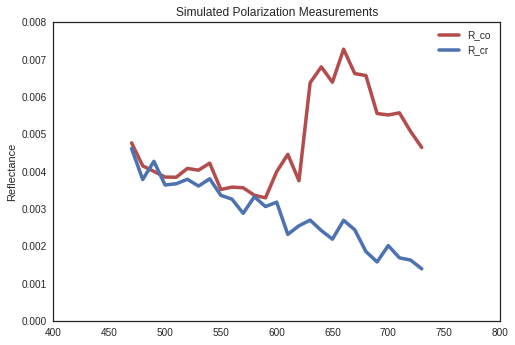

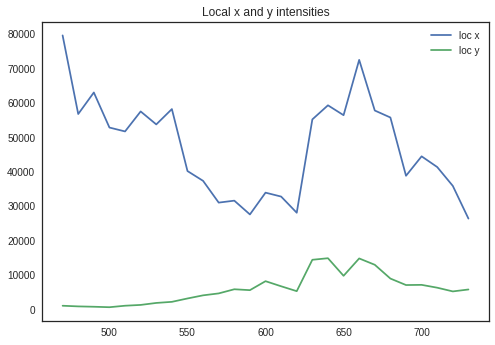

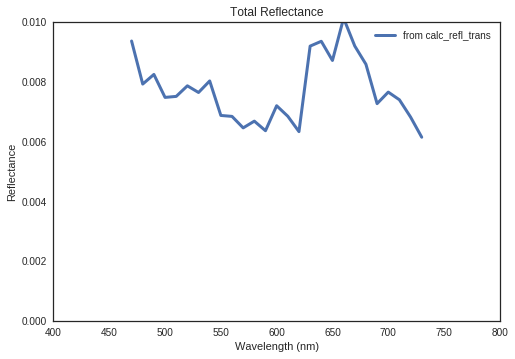

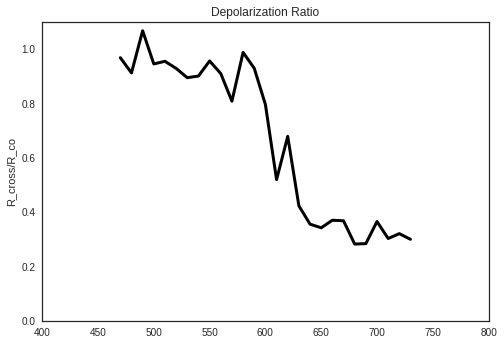

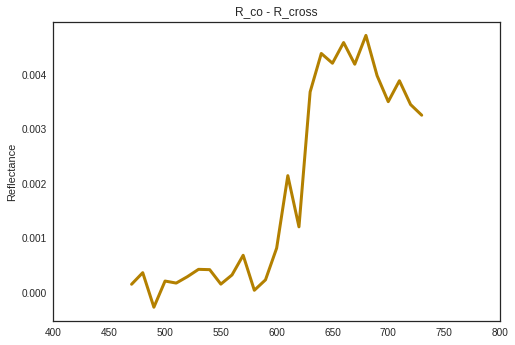

In [15]:
sns.set_style('white')

# this conversion just comes from the geometry of the setup 
R_z = (-pol_refl_z_sum*np.cos(16*np.pi/180) + pol_refl_x_sum*np.sin(16*np.pi/180))/ntrajectories
R_cr = pol_refl_y_sum/ntrajectories
R_co = (pol_refl_z_sum*np.sin(16*np.pi/180) + pol_refl_x_sum*np.cos(16*np.pi/180))/ntrajectories
#I_co = (np.sqrt(pol_refl_z_sum)*np.sin(16*np.pi/180) + np.sqrt(pol_refl_x_sum)*np.cos(16*np.pi/180))**2/ntrajectories

plt.figure()
plt.plot(wavelengths, R_co , label = 'R_co', linewidth = 3.5, color = [0.7,0.3,0.3])
plt.plot(wavelengths, R_cr, label = 'R_cr', linewidth = 3.5)
plt.xlim([400,800])
plt.ylim([0,0.008])
#plt.plot(wavelengths, I_z, label = 'I_z')
#plt.ylim([0,5000])
plt.ylabel('Reflectance')
plt.title('Simulated Polarization Measurements')
plt.legend()
plt.savefig('cocross.pdf')

plt.figure()
plt.title('Local x and y intensities')
plt.plot(wavelengths, pol_refl_loc_x_sum**2, label = 'loc x')
plt.plot(wavelengths, pol_refl_loc_y_sum**2, label = 'loc y')
#plt.plot(wavelengths, pol_refl_loc_y_sum**2/pol_refl_loc_x_sum**2, label = 'ratio')
plt.legend()

plt.figure()
plt.title('Total Reflectance')
plt.plot(wavelengths, reflectance, linewidth = 3, label = 'from calc_refl_trans')
#plt.plot(wavelengths, R_co + R_cr, linewidth = 3, label = 'R_co + R_cr')
#plt.plot(wavelengths, R_co + R_cr + R_z, linewidth = 3, label = 'R_co + R_cr + R_z')
plt.xlim([400,800])
plt.ylim([0,0.01])
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.legend()
plt.savefig('total_refl.pdf')

plt.figure()
plt.plot(wavelengths, R_cr/R_co, linewidth = 3, color = [0,0,0])
plt.title('Depolarization Ratio')
plt.ylabel('R_cross/R_co')
plt.ylim([0,1.1])
plt.xlim([400,800])
plt.savefig('depolarization.pdf')

plt.figure()
plt.ylabel('Reflectance')
plt.title('R_co - R_cross')
plt.plot(wavelengths, R_co - R_cr, linewidth = 3, color = [0.7,0.5,0])
plt.xlim([400,800])
plt.savefig('cominuscr.pdf')

### Plot average polarizations over time

(0, 10)

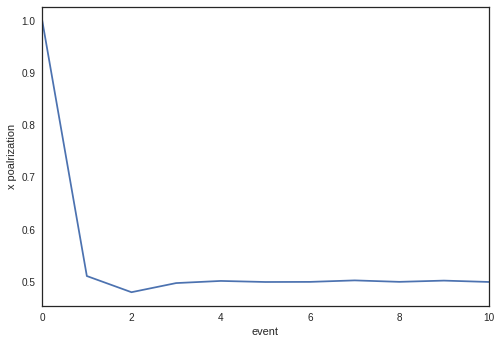

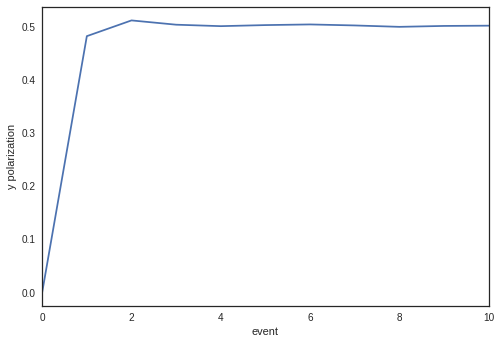

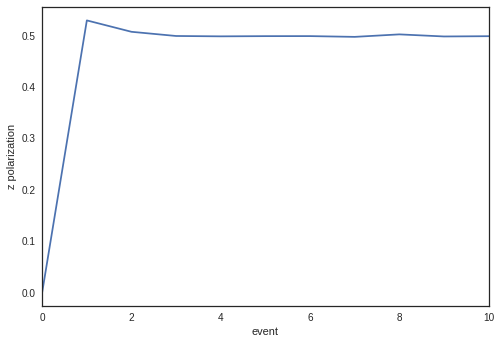

In [5]:
# x, nevent, ntraj
plt.figure()
pol_x_mean = np.mean(np.abs(trajectories.polarization[0,:,:]),axis=1)
plt.plot(pol_x_mean)
plt.ylabel('x poalrization')
plt.xlabel('event')
plt.xlim([0,10])

plt.figure()
pol_y_mean = np.mean(np.abs(trajectories.polarization[1,:,:]),axis=1)
plt.plot(pol_y_mean)
plt.ylabel('y polarization')
plt.xlabel('event')
plt.xlim([0,10])

plt.figure()
pol_z_mean = np.mean(np.abs(trajectories.polarization[2,:,:]),axis=1)
plt.plot(pol_z_mean)
plt.ylabel('z polarization')
plt.xlabel('event')
plt.xlim([0,10])

### Calculate single scattering model

In [6]:
refl = np.zeros(wavelengths.size)
refl_par = np.zeros(wavelengths.size)
refl_perp = np.zeros(wavelengths.size)
for i in range(wavelengths.size):
    refl[i], refl_par[i], refl_perp[i], _, _ = sc.model.reflection(n_particle[i], n_matrix[i],
                                                     n_medium[i], wavelengths[i],
                                                     particle_radius, volume_fraction, 
                                                     thickness = thickness,
                                                     theta_min = sc.Quantity('170 deg'), #158
                                                     theta_max = sc.Quantity('180 deg'), #170
                                                     phi_min = sc.Quantity('0 deg'),
                                                     phi_max = sc.Quantity('360 deg'))
    

refl_2 = np.zeros(wavelengths.size)
refl_par_2 = np.zeros(wavelengths.size)
refl_perp_2 = np.zeros(wavelengths.size)    
for i in range(wavelengths.size):
    refl_2[i], refl_par_2[i], refl_perp_2[i], _, _ = sc.model.reflection(n_particle[i], n_matrix[i],
                                                     n_medium[i], wavelengths[i],
                                                     particle_radius, volume_fraction, 
                                                     thickness = thickness,
                                                     theta_min = sc.Quantity('90 deg'), #158
                                                     theta_max = sc.Quantity('100 deg'), #170
                                                     phi_min = sc.Quantity('0 deg'),
                                                     phi_max = sc.Quantity('360 deg'))


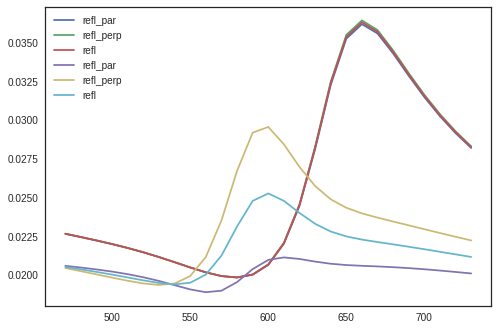

In [7]:
plt.figure()
plt.plot(wavelengths, refl_par, label = 'refl_par')
plt.plot(wavelengths, refl_perp, label = 'refl_perp')
plt.plot(wavelengths, refl, label = 'refl')

plt.plot(wavelengths, refl_par_2, label = 'refl_par')
plt.plot(wavelengths, refl_perp_2, label = 'refl_perp')
plt.plot(wavelengths, refl_2, label = 'refl')
plt.legend()

### Plot phase function in theta and phi

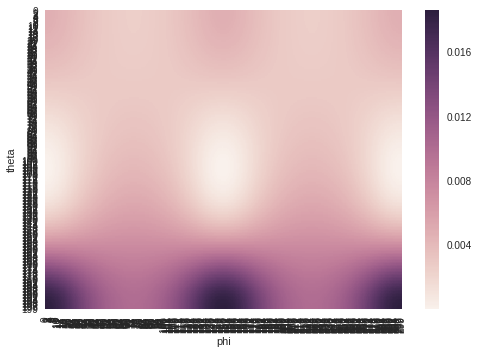

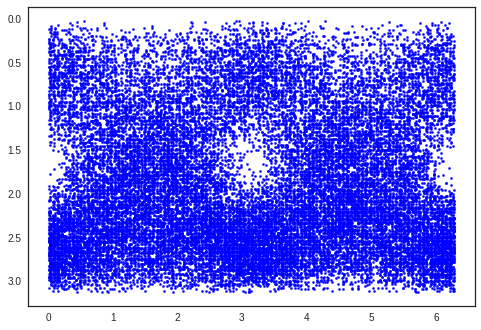

In [8]:
ax = sns.heatmap(p)
plt.xlabel('phi')
plt.ylabel('theta')

plt.figure()
plt.scatter(phi[0,:], theta[0,:], color = 'b', s = 5)
plt.gca().invert_yaxis()
#plt.scatter(phi[1,:], np.flip(theta[1,:]), color = 'b', s =5)